In [1]:
import matplotlib.pyplot as plt
import matplotlib
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
matplotlib.rcParams['text.usetex'] = True
import pandas as pd
import numpy as np
import random
import os
from scipy.sparse.linalg.eigen.arpack import eigsh as largest_eigsh
import time
import networkx as nx
from sklearn.cluster import KMeans

plt.rcParams['axes.unicode_minus']=False

path = 'result/windowed-esn'
if not os.path.exists(path):
    os.makedirs(path)
    

class Timer(object):
    def __enter__(self):
        self.t0 = time.time()
    def __exit__(self, exc_type, exc_val, exc_tb):
        print('[time spent: {time:.2f}s]'.format(time = time.time() - self.t0))

In [34]:
t0 = time.time()
seed = 42
random.seed(seed) 
np.random.seed(seed)
system_name = 'Lorenz'
for inputdata, dim in zip(
    [
        'x',
        'y',
        'z', 
        'xyz',
#         'xy',
#         'yz',
#         'xz'
    ],[
        [0],
        [1],
        [2],
        [0,1,2],
#         [0,1],
#         [1,2],
#         [0,2]
    ]):
    print(inputdata)

    Y = np.loadtxt('dataset/matlab_gendata/'+system_name+'.csv', delimiter=',').T
    U0 = Y[dim].copy()
    U = U0 + np.random.randn(*U0.shape)*1e-3
    U = np.atleast_2d(U)

    num_prepare = 1000
    train_start = num_prepare
    num_train = 10000
    val_start = num_prepare + num_train
    num_val = 1000
    test_start = num_prepare + num_train + num_val
    num_test = 5000
    print('U shape:', U.shape)
    print('Y shape:', Y.shape)


    inSize = U.shape[0]
    outSize = 3  
    resSize = 100
    reg = 1e-6 
    length = 20

    Y_train = Y[:,train_start + length  : train_start + num_train + length ]
    Y_test = Y[:,test_start + length  : test_start + num_test + length ]
    
    filename = path+'/system={},seed={},Nx={},input={}'.format(system_name,seed, resSize, inputdata) + '.csv'
    if os.path.exists(filename):
        os.remove(filename)

    times=0
    for a in [0.1*i for i in range(1, 11)]:           # leaking rate
        for K in [0.2*i for i in range(1,11)]:          # spectial redius
          # regularization coefficient 
            for input_scaling in [0.2*i for i in range(1,11)]:

                times += 1
                if times %100 == 0:
                    print(times)

                # generation of random weights
                random.seed(seed) 
                np.random.seed(seed)

                Win = (np.random.rand(resSize,1+inSize)-0.5) * (input_scaling * 2)
                W = np.random.rand(resSize,resSize)-0.5
                largest_eigvals, _ = largest_eigsh(W@W.T, 1, which='LM')
                rhoW = np.sqrt(largest_eigvals[0])
                W = W/rhoW*K 

                X = np.zeros((resSize,U.shape[1]-length))
                for t in range(length):
                    X = (1-a) * X + a * np.tanh(Win @ np.vstack((np.ones((1,U.shape[1]-length)),U[:,t:-length+t])) + W @ X) 
                
                
                # offline train
                X_train = X[:,train_start : train_start + num_train]
                H = np.vstack((np.ones((1,X_train.shape[1])),X_train))

                Wout = Y_train @ H.T @ np.linalg.inv( H @ H.T + reg*np.eye(H.shape[0]))
#                 err = np.average(np.square(Y_train - Wout@H), axis=1)

                X_test = X[:,test_start : test_start + num_test]
                err = Y_test - Wout @ np.vstack((np.ones((1,X_test.shape[1])),X_test))
                err = np.average(np.square(err), axis=1)
#                 print(err)

                with open(filename, 'a') as file:
                    file.write('{},{},{},{},{},{}\n'.format(round(a,2), round(K,2), round(input_scaling,2), err[0],err[1],err[2]))

    print('[time spent: {time:.2f}s]'.format(time = time.time() - t0))

x
U shape: (1, 20000)
Y shape: (3, 20000)
100
200
300
400
500
600
700
800
900
1000
[time spent: 1114.88s]
y
U shape: (1, 20000)
Y shape: (3, 20000)
100
200
300
400
500
600
700
800
900
1000
[time spent: 2209.70s]
z
U shape: (1, 20000)
Y shape: (3, 20000)
100
200
300
400
500
600
700
800
900
1000
[time spent: 3343.63s]
xyz
U shape: (3, 20000)
Y shape: (3, 20000)
100
200
300
400
500
600
700
800
900
1000
[time spent: 4470.43s]


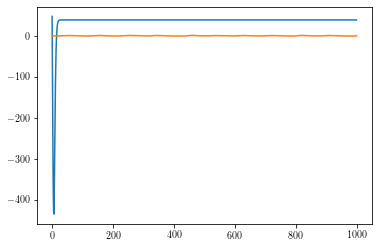

In [33]:
num_test = 1
horizon = 1000
pred = np.zeros((outSize,horizon))

def predict(U):
    X = np.zeros((resSize,U.shape[1]))
    for t in range(length):
        X = (1-a) * X + a * np.tanh(Win @ np.vstack([np.ones((1,U.shape[1])),U[inSize*t:inSize*(t+1)]]) + W @ X) 
    H = np.vstack((np.ones((1,U.shape[1])),X))
    return Wout @ H


for h in range(horizon):
    if h == 0:
        U_test = np.vstack([U[:,test_start + i: test_start + num_test + i] for i in range(length)])
    else:
        U_test = np.vstack([U_test[inSize:], Y_pred[dim]])

           
    Y_pred = predict(U_test)
    pred[:,h:h+1] = Y_pred

plt.figure()
plt.plot(pred[0])
plt.plot(U[0,test_start : test_start + horizon])